In [39]:
# sytem lib
import os

import matplotlib.pyplot as plt

# common lib
import numpy as np
import segmentation_models_pytorch as smp

# torh lib
import torch as torch
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import Adam, SGD
from tqdm import tqdm

DATA_DIR = './dataset'
IMAGE_SIZE = 256

# determine the device to be used for training and evaluation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == 'cuda' else False

load_dotenv()

True

### Utilities

In [40]:
# helper function for data visualization


def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# 1. Data

## 1.1 Download data

In [41]:
from google_drive_downloader import GoogleDriveDownloader as gdd

FILE_ID = os.getenv('FILE_ID')

if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.makedirs(DATA_DIR)
    dest_path = os.path.join(DATA_DIR, 'dataset.zip')
    gdd.download_file_from_google_drive(
        file_id=FILE_ID,
        dest_path=dest_path,
        unzip=True,
    )
    print('Done!')

## 1.2 Define dataset

In [42]:
import cv2
from torch.utils.data import Dataset


class MedPatDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, preprocessing, augmentation):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.preprocessing = preprocessing
        self.augmentation = augmentation

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        class_label = float(np.sum(mask) > 0)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))

        # check to see if we are applying any transformations
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image)
            mask = self.preprocessing(mask)

        # return a tuple of the image and its mask
        return (image, mask, class_label)

## 1.3 Split to train and test

In [43]:
TEST_SPLIT = 0.2


def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]


imagePaths = list_full_paths(os.path.join(DATA_DIR, 'images'))
maskPaths = list_full_paths(os.path.join(DATA_DIR, 'masks'))

train_img, test_img, train_masks, test_masks = train_test_split(
    imagePaths, maskPaths, test_size=TEST_SPLIT, random_state=42
)
print(f'Train size = {len(train_img)}')
print(f'Test size = {len(test_img)}')


Train size = 160
Test size = 40


Image and mask for class 0.0


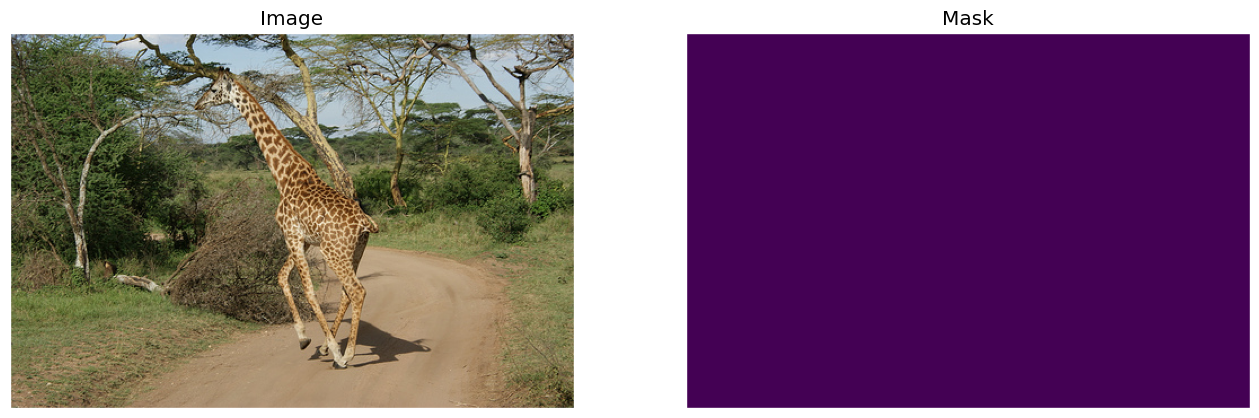

In [44]:
# just look on raw data
train_dataset = MedPatDataset(train_img, train_masks, None, None)
test_dataset = MedPatDataset(test_img, test_masks, None, None)

image, mask, class_label = train_dataset[1]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

Image and mask for class 1.0


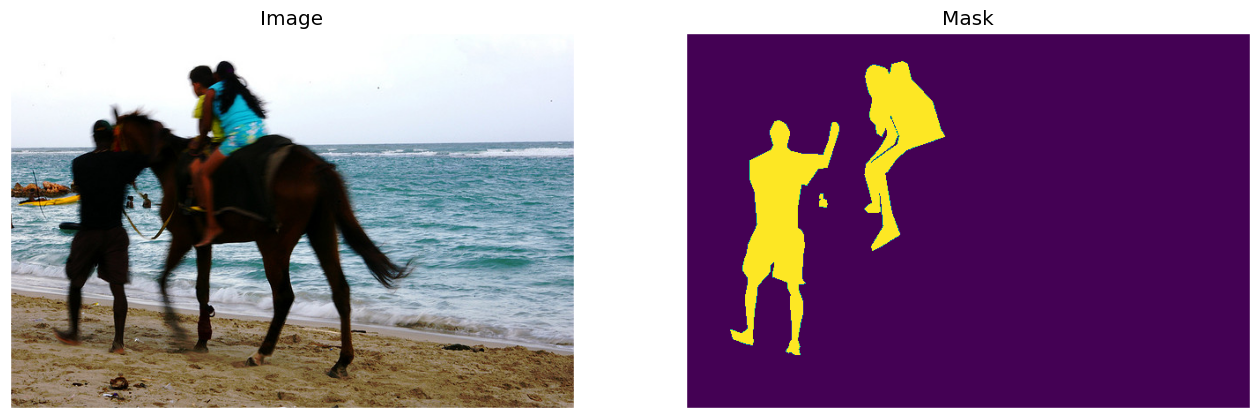

In [45]:
image, mask, class_label = train_dataset[10]  # get some sample
print(f'Image and mask for class {class_label}')
visualize(
    image=image,
    mask=mask.squeeze(),
)

## 1.4 Check class balance

In [46]:
train_class_1 = 0
for images, gt_masks, class_label in train_dataset:
    if class_label == 1:
        train_class_1 += 1
test_class_1 = 0
for images, gt_masks, class_label in test_dataset:
    if class_label == 1:
        test_class_1 += 1
print(
    f'proportion of positive class in train data {train_class_1/len(train_dataset):.4f}'
)
print(
    f'proportion of positive class in test data {test_class_1/len(test_dataset):.4f}'
)


proportion of positive class in train data 0.4875
proportion of positive class in test data 0.5500


## 1.5 Preprocessing and Augmentations

In [47]:
# convert input data to encoder needs format
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [48]:
import albumentations as albu


def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        albu.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True
        ),
        # albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
    ]
    return albu.Compose(train_transform, is_check_shapes=False)


def to_tensor(x, **kwargs):
    import torchvision.transforms as transforms

    transform = transforms.Compose([transforms.ToTensor()])

    return transform(x)


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


image, mask, cls = train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=None,
    augmentation=None,
)[0]
conv_img = preprocessing_fn(image)
conv_mask = preprocessing_fn(mask)
v = 1

Image and mask for class 1.0


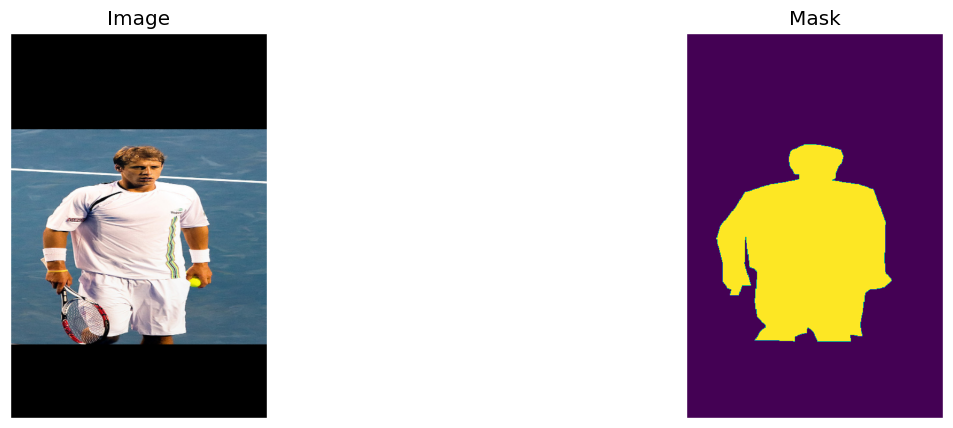

Image and mask for class 0.0


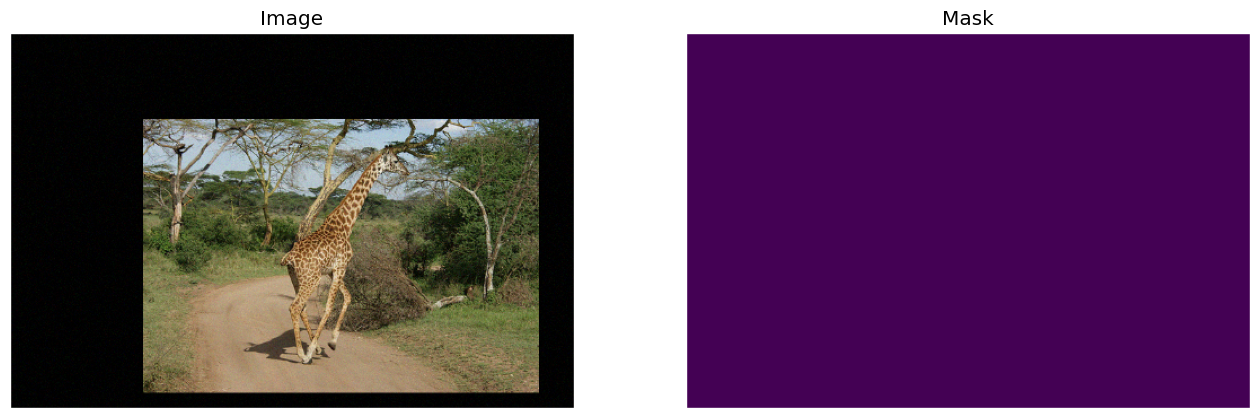

Image and mask for class 0.0


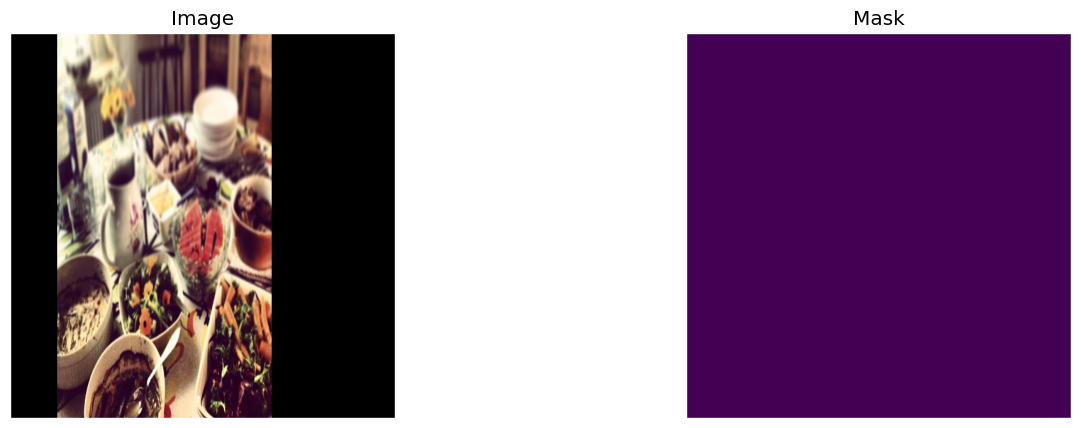

Image and mask for class 0.0


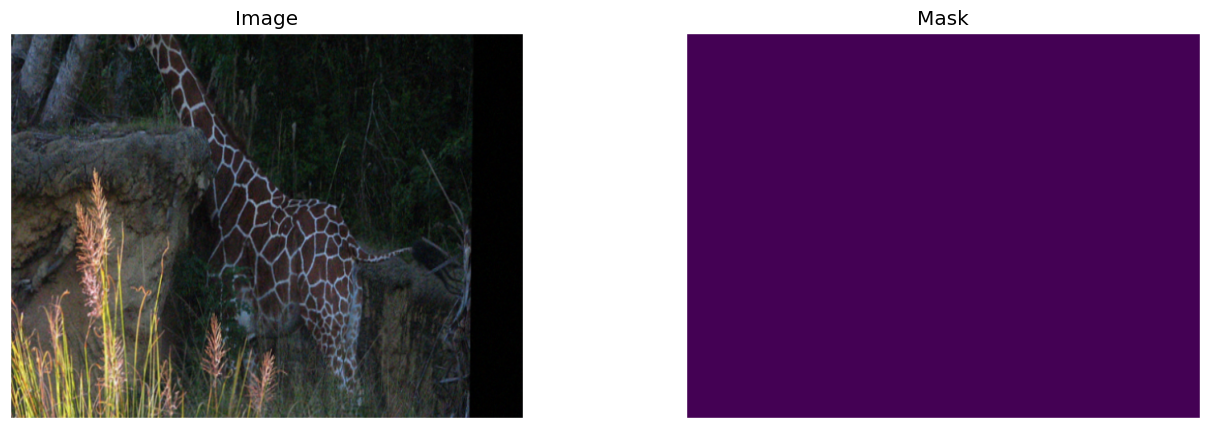

Image and mask for class 1.0


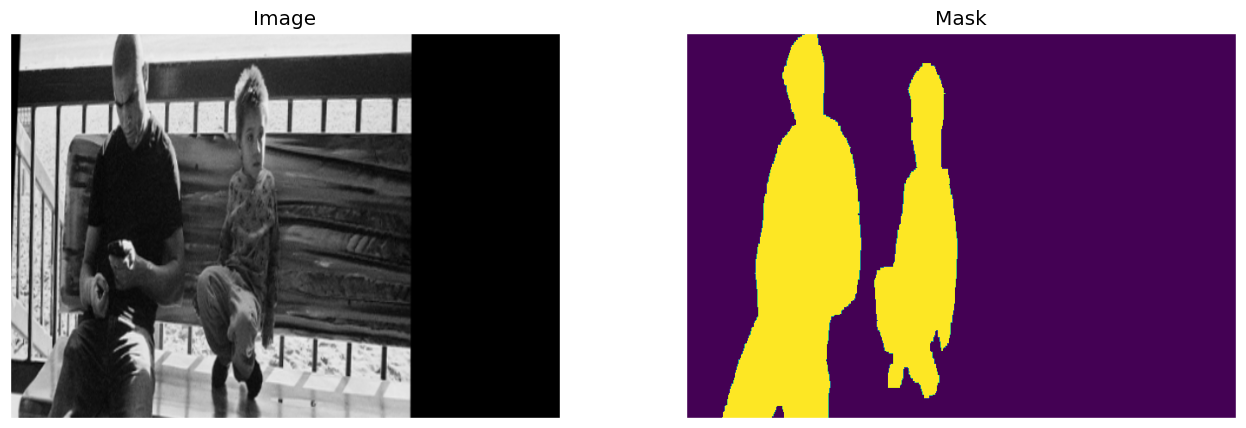

Image and mask for class 1.0


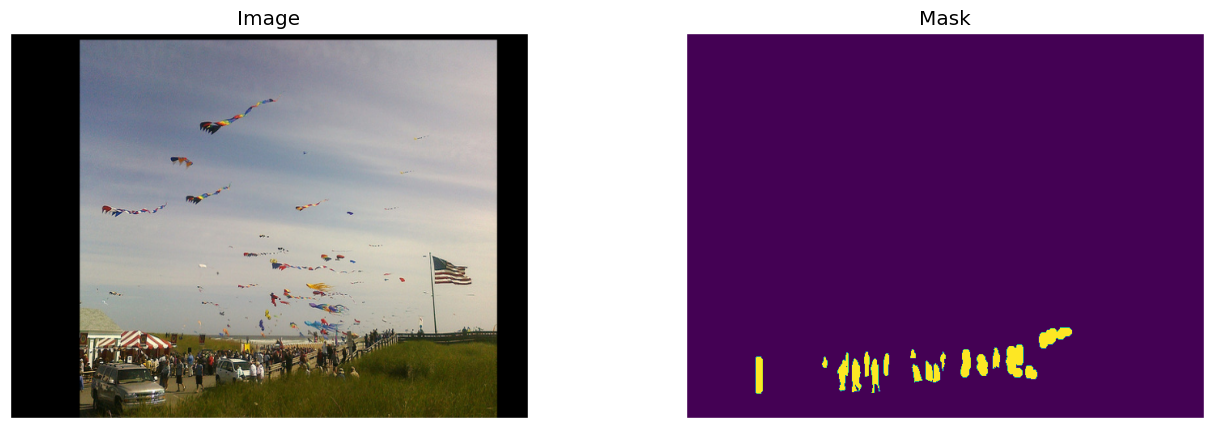

Image and mask for class 1.0


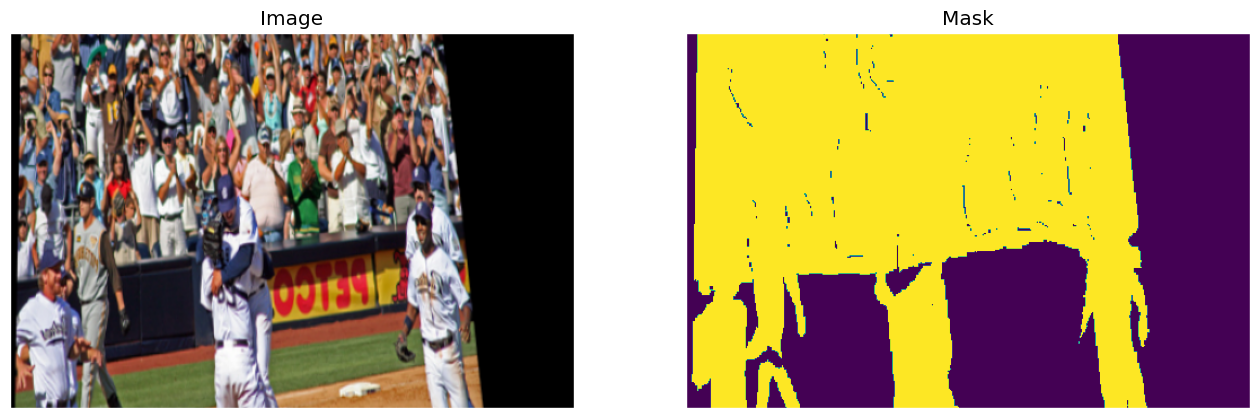

Image and mask for class 0.0


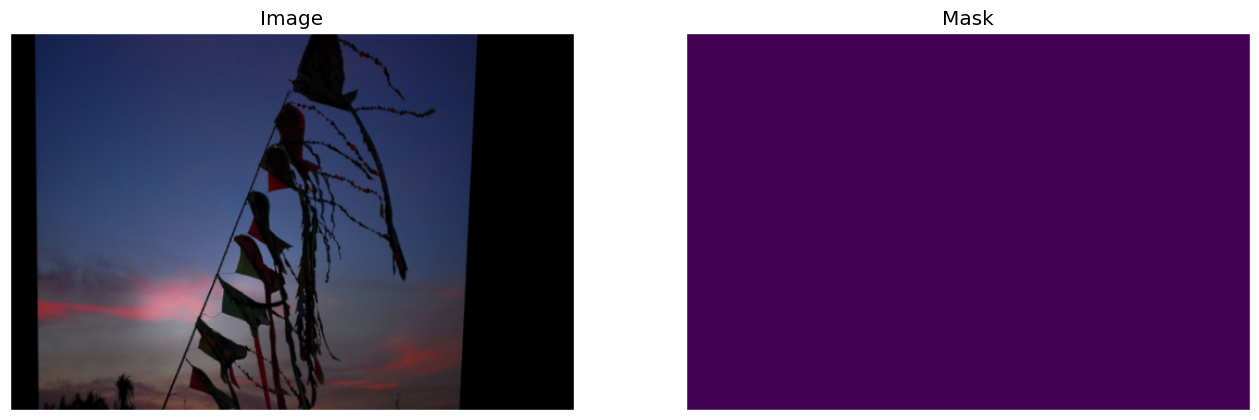

Image and mask for class 1.0


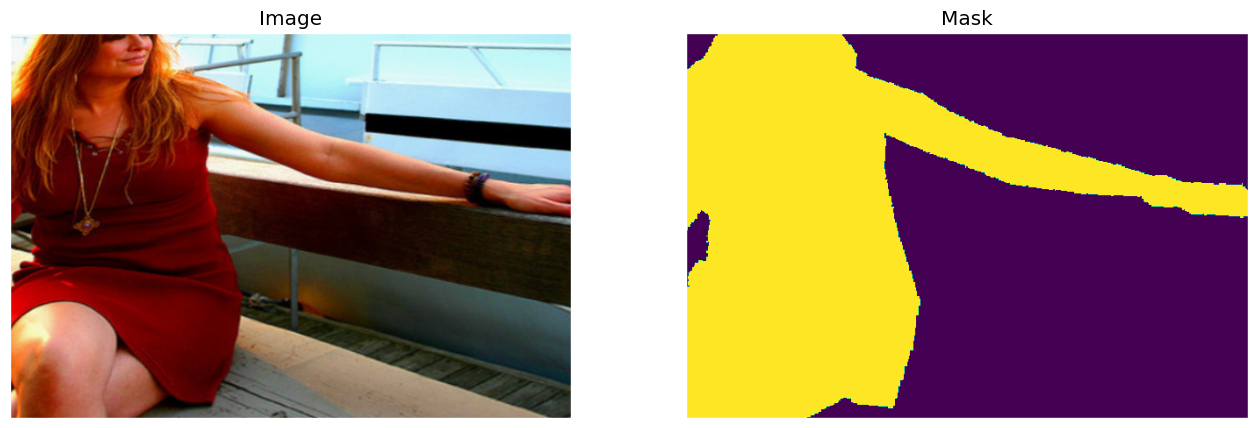

Image and mask for class 1.0


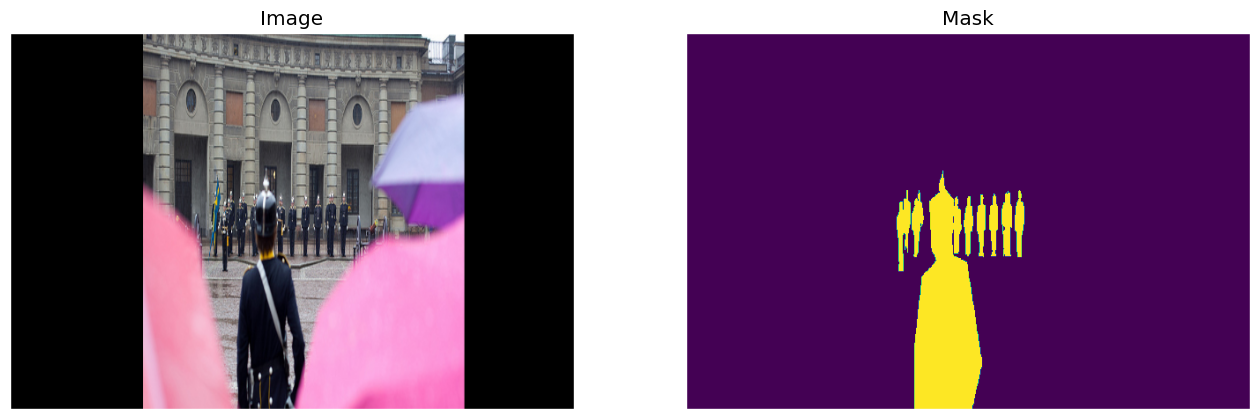

In [49]:
# visual check  work of augmentation
train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=None,  # get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=None,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(5):
    image, mask, class_label = train_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# same image with different random transforms
for i in range(5):
    image, mask, class_label = test_dataset[i]
    print(f'Image and mask for class {class_label}')
    visualize(image=image, mask=mask.squeeze())

# 2. Define and train model

In [50]:
# target output size of 5x7
m = nn.AdaptiveAvgPool2d(output_size=1)
f = nn.Flatten(start_dim=1, end_dim=-1)
input = torch.randn(4, 100, 256, 256)
output = m(input)
output = f(output)
output.shape

torch.Size([4, 100])

In [51]:
class Encoder(nn.Module):
    def __init__(
        self,
        number_layers,
        kernel_size=3,
        in_channels=3,
        out_channels=100,
        dropout_rate=0.2,
    ):
        super().__init__()

        self.seq = nn.Sequential()
        self.seq.add_module(
            name='input_dropout', module=nn.Dropout(p=dropout_rate)
        )
        step = int(out_channels // number_layers)
        current_out = step
        prev_out = current_out
        for i in range(number_layers):
            if i == 0:
                self.seq.add_module(
                    name=f'conv2d_{i}',
                    module=nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=current_out,
                        kernel_size=kernel_size,
                        stride=1,
                        padding=1,
                    ),
                )
            elif i == (number_layers - 1):
                self.seq.add_module(
                    name=f'conv2d_{i}',
                    module=nn.Conv2d(
                        in_channels=prev_out,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        stride=1,
                        padding=1,
                    ),
                )
            else:
                self.seq.add_module(
                    name=f'conv2d_{i}',
                    module=nn.Conv2d(
                        in_channels=prev_out,
                        out_channels=current_out,
                        kernel_size=kernel_size,
                        stride=1,
                        padding=1,
                    ),
                )
            prev_out = current_out
            current_out += step

            self.seq.add_module(name=f'reLU_{i}', module=nn.ReLU())
            self.seq.add_module(
                name=f'dropout_{i}', module=nn.Dropout(p=dropout_rate)
            )

    def forward(self, x):
        x = self.seq(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoder, dropout_rate=0.2):
        super().__init__()
        self.seq = nn.Sequential(*self._invert_(encoder, dropout_rate))

    def _invert_(self, encoder, dropout_rate=0.2):
        """Invert the encoder in order to create the decoder as a mirror image of the encoder

        Args:
            encoder (ModuleList): the encoder

        Returns:
            decoder (ModuleList): the decoder obtained by "inversion" of encoder

        """
        modules_transpose = []
        for module in reversed(encoder.seq):
            if isinstance(module, nn.Conv2d):
                kwargs = {
                    'in_channels': module.out_channels,
                    'out_channels': module.in_channels,
                    'kernel_size': module.kernel_size,
                    'stride': module.stride,
                    'padding': module.padding,
                }
                module_transpose = nn.ConvTranspose2d(**kwargs)
                module_dropout = nn.Dropout(p=dropout_rate)
                module_act = nn.ReLU(inplace=True)
                modules_transpose += [
                    module_dropout,
                    module_transpose,
                    module_act,
                ]

        modules_transpose = modules_transpose[:-1]
        # modules_transpose.append(nn.Sigmoid())

        return modules_transpose

    def forward(self, x):
        x = self.seq(x)
        return x


class Classifier(nn.Module):
    def __init__(
        self,
        out_channels=100,
        n_classes=1,
    ):
        super().__init__()

        self.seq = nn.Sequential()
        hidden_layers = int(out_channels // 2)
        self.seq.add_module(
            name='avg_pool',
            module=nn.AdaptiveAvgPool2d(output_size=1),
        )
        self.seq.add_module(
            name='flatten', module=nn.Flatten(start_dim=1, end_dim=-1)
        )
        self.seq.add_module(
            name='linear_1',
            module=nn.Linear(
                in_features=out_channels, out_features=hidden_layers
            ),
        )
        self.seq.add_module(name='reLU_1', module=nn.ReLU(inplace=True))
        self.seq.add_module(
            name='linear_2',
            module=nn.Linear(in_features=hidden_layers, out_features=n_classes),
        )
        self.seq.add_module(name='sigmoid', module=nn.Sigmoid())

    def forward(self, x):
        x = self.seq(x)
        return x


class UNetSegmentationClassifier(nn.Module):
    def __init__(
        self,
        number_layers=3,
        kernel_size=3,
        in_channels=3,
        out_channels=100,
        n_classes=1,
        dropout_rate=0.2,
    ):
        super().__init__()
        # parametrs of NN
        self.number_layers = number_layers
        self.kernel_size = kernel_size
        self.encoder = Encoder(
            number_layers, kernel_size, in_channels, out_channels, dropout_rate
        )
        self.decoder = Decoder(self.encoder, dropout_rate)
        self.head = nn.Conv2d(in_channels, n_classes, kernel_size=1)

        self.classifier = Classifier(out_channels=out_channels, n_classes=1)

    def forward(self, x):
        encoder_out = self.encoder(x)
        out = self.decoder(encoder_out)
        out = self.head(out)

        class_label = self.classifier(encoder_out)
        return out, class_label


In [52]:
unet = UNetSegmentationClassifier().to(DEVICE)
unet

UNetSegmentationClassifier(
  (encoder): Encoder(
    (seq): Sequential(
      (input_dropout): Dropout(p=0.2, inplace=False)
      (conv2d_0): Conv2d(3, 33, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (reLU_0): ReLU()
      (dropout_0): Dropout(p=0.2, inplace=False)
      (conv2d_1): Conv2d(33, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (reLU_1): ReLU()
      (dropout_1): Dropout(p=0.2, inplace=False)
      (conv2d_2): Conv2d(66, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (reLU_2): ReLU()
      (dropout_2): Dropout(p=0.2, inplace=False)
    )
  )
  (decoder): Decoder(
    (seq): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): ConvTranspose2d(100, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): ConvTranspose2d(66, 33, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Dropout(p=0.2, inplace=Fa

In [53]:
INIT_LR = 0.001


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        import torch.nn.functional as F

        inputs = F.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.0 * intersection) / (inputs.sum() + targets.sum())

        return 1 - dice


DICE = DiceLoss()
BCE = nn.BCEWithLogitsLoss()

opt_seg = SGD(
    [
        {'params': unet.encoder.parameters()},
        {'params': unet.decoder.parameters()},
        {'params': unet.head.parameters()},
    ],
    lr=INIT_LR,
)
opt_cls = SGD([{'params': unet.classifier.parameters()}], lr=INIT_LR)


def metrics(y_pred, y_test):
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    return {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
    }


In [54]:
import warnings

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')

BATCH_SIZE = 16
NUM_EPOCHS = 100

transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]
)

train_dataset = MedPatDataset(
    train_img,
    train_masks,
    preprocessing=transforms,
    augmentation=get_training_augmentation(),
)
test_dataset = MedPatDataset(
    test_img,
    test_masks,
    preprocessing=transforms,
    augmentation=get_training_augmentation(),
)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY
)

print('[INFO] training the network...')
# history log
H = {
    'train_loss': [],
    'train_loss_seg': [],
    'train_loss_cls': [],
    'test_loss': [],
    'recall': [],
    'accuracy': [],
    'precision': [],
}
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    # initialize the total training and validation loss
    train_loss = 0
    train_loss_seg = 0
    train_loss_cls = 0
    test_loss = 0
    recall = 0
    accuracy = 0
    precision = 0
    train_steps = 0
    test_steps = 0

    for images, gt_masks, class_label in train_loader:
        train_steps += 1

        (images, gt_masks, class_label) = (
            images.to(DEVICE, dtype=torch.float),
            gt_masks.to(DEVICE),
            class_label.to(DEVICE),
        )
        predicted_mask, _ = unet(images)

        loss_seg = BCE(predicted_mask, gt_masks)

        opt_seg.zero_grad()
        loss_seg.backward()
        opt_seg.step()

        _, labels = unet(images)

        loss_cls = BCE(labels, class_label.unsqueeze(1))

        opt_cls.zero_grad()
        loss_cls.backward()
        opt_cls.step()

        loss = loss_seg + loss_cls
        train_loss += loss
        train_loss_seg += loss_seg
        train_loss_cls += loss_cls

    # set the model in evaluation mode
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        for images, gt_masks, class_label in test_loader:
            test_steps += 1
            (images, gt_masks, class_label) = (
                images.to(DEVICE, dtype=torch.float),
                gt_masks.to(DEVICE),
                class_label.to(DEVICE),
            )
            predicted_mask, labels = unet(images)

            loss_test = BCE(predicted_mask, gt_masks)
            +BCE(labels, class_label.unsqueeze(1))
            test_loss += loss_test

            # metric calc
            y_pred = labels.view(-1).cpu().detach().numpy().round()
            y_true = class_label.view(-1).cpu().detach().numpy()
            batch_metircs = metrics(y_pred, y_true)
            precision += batch_metircs['precision']
            accuracy += batch_metircs['accuracy']
            recall += batch_metircs['recall']

            if e > 1 and e % 10 == 0:
                torch.save(unet, 'unet_medpat.pt')

    # calculate the average training and test loss
    avg_train_loss = train_loss / train_steps
    avg_test_loss = test_loss / test_steps
    avg_loss_seg = train_loss_seg / train_steps
    avg_loss_cls = train_loss_cls / train_steps
    avg_recall = recall / test_steps
    avg_precision = precision / test_steps
    avg_accuracy = accuracy / test_steps
    H['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    H['train_loss_seg'].append(avg_loss_seg.cpu().detach().numpy())
    H['train_loss_cls'].append(avg_loss_cls.cpu().detach().numpy())
    H['test_loss'].append(avg_test_loss.cpu().detach().numpy())
    H['recall'].append(avg_recall)
    H['precision'].append(avg_precision)
    H['accuracy'].append(avg_accuracy)

    torch.save(unet, 'unet_medpat.pt')

    if e % 10 == 0:
        print(f'[INFO] EPOCH: {e+1}/{NUM_EPOCHS}')
        print(
            f'Train loss: {avg_train_loss:.6f}, test loss {avg_test_loss:.6f}'
        )
        print(
            f'Train loss seg: {avg_loss_seg:.6f}, train loss cls {avg_loss_cls:.6f}'
        )
        print(
            f'EPOCH metrics: accuracy {avg_accuracy:.4f}, recall {avg_recall:.4f}, precision {avg_precision:.4f}'
        )

[INFO] training the network...


  1%|          | 1/100 [05:24<8:54:46, 324.11s/it]

[INFO] EPOCH: 1/100
Train loss: 1.261545, test loss 0.557228
Train loss seg: 0.528616, train loss cls 0.732929
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 11%|█         | 11/100 [59:47<8:10:14, 330.50s/it]

[INFO] EPOCH: 11/100
Train loss: 1.224551, test loss 0.527430
Train loss seg: 0.491793, train loss cls 0.732758
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 21%|██        | 21/100 [1:47:14<6:19:06, 287.93s/it]

[INFO] EPOCH: 21/100
Train loss: 1.194493, test loss 0.508507
Train loss seg: 0.461914, train loss cls 0.732579
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 31%|███       | 31/100 [2:33:31<5:12:55, 272.11s/it]

[INFO] EPOCH: 31/100
Train loss: 1.154666, test loss 0.490523
Train loss seg: 0.422287, train loss cls 0.732379
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 41%|████      | 41/100 [3:19:21<4:32:16, 276.89s/it]

[INFO] EPOCH: 41/100
Train loss: 1.127800, test loss 0.466185
Train loss seg: 0.395575, train loss cls 0.732224
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 51%|█████     | 51/100 [4:05:38<3:45:31, 276.15s/it]

[INFO] EPOCH: 51/100
Train loss: 1.105624, test loss 0.430043
Train loss seg: 0.373552, train loss cls 0.732072
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 61%|██████    | 61/100 [4:51:20<2:57:01, 272.35s/it]

[INFO] EPOCH: 61/100
Train loss: 1.070662, test loss 0.442588
Train loss seg: 0.338790, train loss cls 0.731872
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 71%|███████   | 71/100 [5:37:44<2:14:28, 278.23s/it]

[INFO] EPOCH: 71/100
Train loss: 1.051036, test loss 0.400685
Train loss seg: 0.319310, train loss cls 0.731726
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 81%|████████  | 81/100 [6:24:12<1:27:50, 277.38s/it]

[INFO] EPOCH: 81/100
Train loss: 1.025961, test loss 0.423935
Train loss seg: 0.294410, train loss cls 0.731551
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


 91%|█████████ | 91/100 [7:10:19<41:35, 277.25s/it]  

[INFO] EPOCH: 91/100
Train loss: 1.006740, test loss 0.429744
Train loss seg: 0.275355, train loss cls 0.731385
EPOCH metrics: accuracy 0.5417, recall 1.0000, precision 0.5417


100%|██████████| 100/100 [7:52:18<00:00, 283.38s/it]


# 3. Plots grapths loss function and metrisc

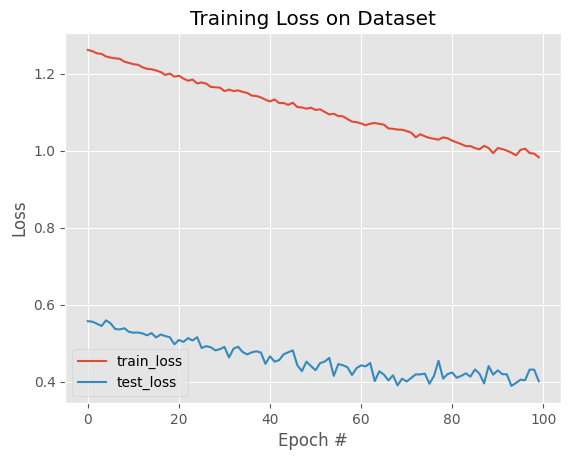

In [55]:
# plot the training/test loss
plt.style.use('ggplot')
plt.figure()
plt.plot(H['train_loss'], label='train_loss')
plt.plot(H['test_loss'], label='test_loss')
plt.title('Training Loss on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')


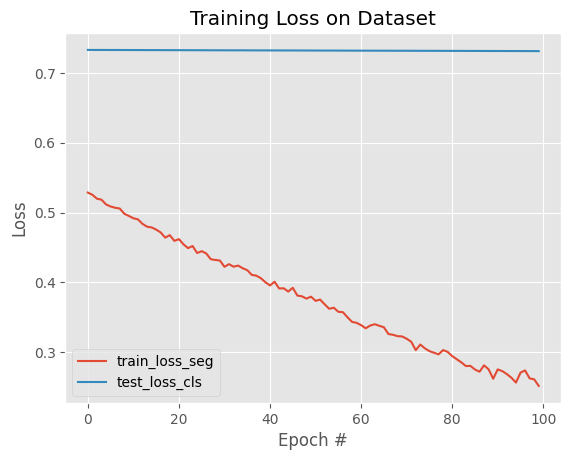

In [56]:
# plot the training/test loss
plt.style.use('ggplot')
plt.figure()
plt.plot(H['train_loss_seg'], label='train_loss_seg')
plt.plot(H['train_loss_cls'], label='test_loss_cls')
plt.title('Training Loss on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')

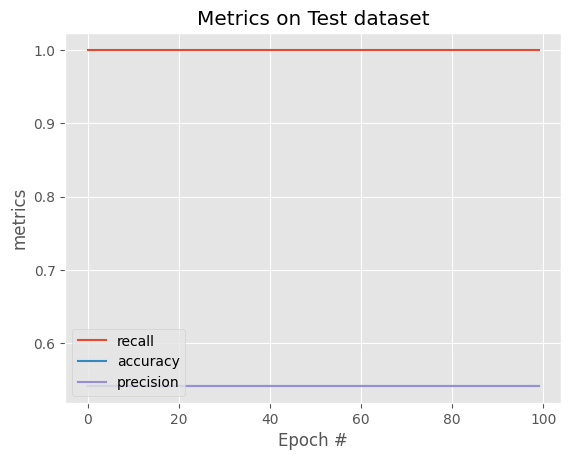

In [57]:
# plot the metrics
plt.style.use('ggplot')
plt.figure()
plt.plot(H['recall'], label='recall')
plt.plot(H['accuracy'], label='accuracy')
plt.plot(H['precision'], label='precision')
plt.title('Metrics on Test dataset')
plt.xlabel('Epoch #')
plt.ylabel('metrics')
plt.legend(loc='lower left')

# 4. Visualize predictions

In [58]:
def classify_image(path_image, path_model):
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np
    import torch

    image_initial = cv2.imread(path_image)
    image = cv2.cvtColor(image_initial, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 320))
    image = np.transpose(image, (2, 0, 1)).astype('float32')
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)

    mask_real = cv2.imread(
        path_image.replace('images', 'masks').replace('jpg', 'png'), 0
    )
    class_label = int((np.sum(mask_real) > 0))

    unet = torch.load(path_model).cpu()
    unet.eval()
    # switch off autograd
    with torch.no_grad():
        predicted_mask, pred_label = unet(image)
        predicted_mask = predicted_mask.squeeze()
        predicted_mask = torch.sigmoid(predicted_mask).numpy()
        # filter out the weak predictions and convert them to integers
        predicted_mask = predicted_mask.round()
        predicted_mask = predicted_mask.astype(np.uint8)
        predicted_mask = np.expand_dims(predicted_mask, 0)
        pred_label = int(torch.sigmoid(pred_label).round())

    # prepare a plot for visualization
    # pred_label = -1
    print(f'Prediction class {pred_label} - real class {class_label}')
    plt.figure(figsize=(16, 5))
    # image
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image_initial)
    # real mask
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Real mask')
    plt.imshow(mask_real)
    # predicted mask
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted mask')
    plt.imshow(predicted_mask[0])
    plt.show()

Prediction class 1 - real class 0


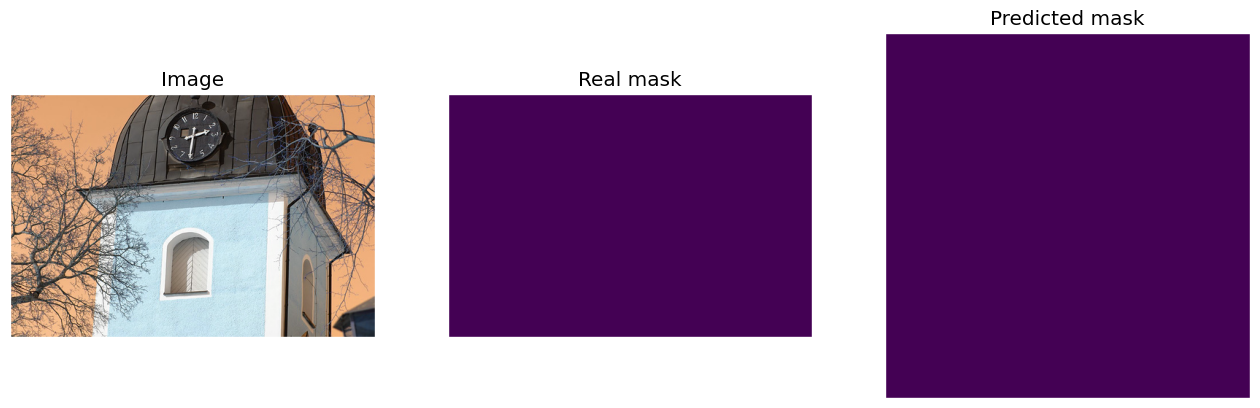

Prediction class 1 - real class 1


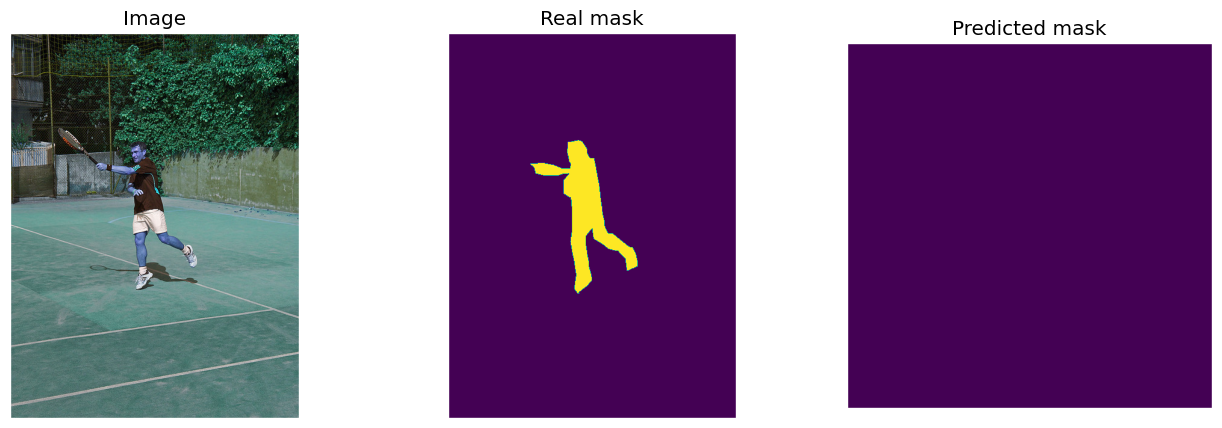

In [59]:
# no human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000009509.jpg'),
    path_model='unet_medpat.pt',
)

# human
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000545525.jpg'),
    path_model='unet_medpat.pt',
)

Prediction class 1 - real class 1


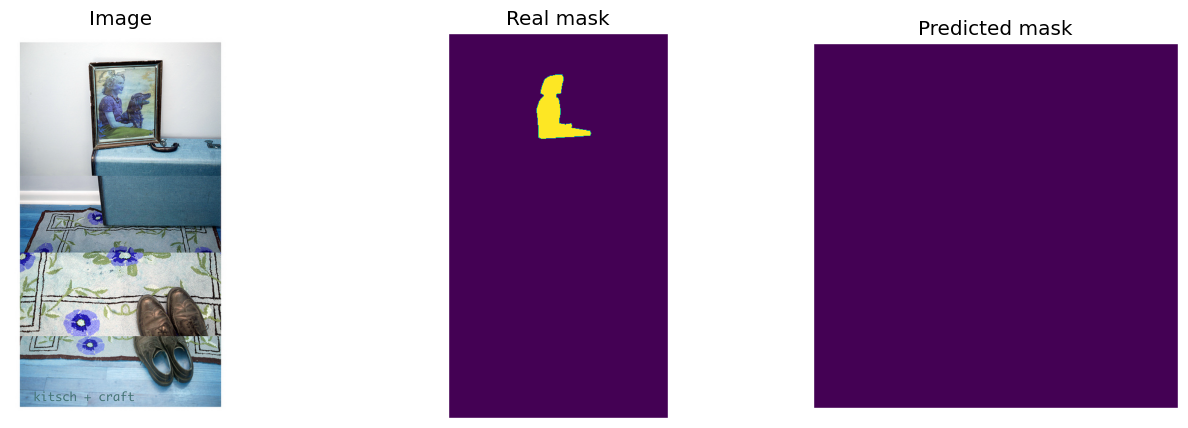

In [60]:
classify_image(
    path_image=os.path.join(DATA_DIR, 'images', '000000535650.jpg'),
    path_model='unet_medpat.pt',
)